In [1]:
%%capture
%%bash

pip install --upgrade scipy flax
pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
pip install --upgrade diffusers transformers

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image
from tqdm.auto import tqdm
# For video display:
from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

In [5]:
from diffusers import FlaxAutoencoderKL, FlaxUNet2DConditionModel, FlaxPNDMScheduler

In [6]:
dtype = jax.numpy.float16

In [7]:
model_id = "CompVis/stable-diffusion-v1-4"
revision = "bf16" # "flax"

In [8]:
%%capture

tokenizer = CLIPTokenizer.from_pretrained(model_id, revision=revision, subfolder="tokenizer", dtype=dtype)
text_encoder = FlaxCLIPTextModel.from_pretrained(model_id, revision=revision, subfolder="text_encoder", dtype=dtype)

Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at CompVis/stable-diffusion-v1-4:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'bias'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'self_attn', 'out_pro

In [9]:
%%capture

vae, vae_params = FlaxAutoencoderKL.from_pretrained(model_id, revision=revision, subfolder="vae", dtype=dtype)
unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(model_id, revision=revision, subfolder="unet", dtype=dtype)

In [10]:
%%capture

scheduler, scheduler_params = FlaxPNDMScheduler.from_pretrained(model_id, revision=revision, subfolder="scheduler")

In [11]:
seed = 123
num_samples = jax.device_count()
prng_seed = jax.random.PRNGKey(seed)
prng_seed = jax.random.split(prng_seed, num_samples)

In [28]:
guidance_scale = 8 #@param {type:"slider", min:0, max:100, step:0.5}
num_inference_steps = 30 #@param 

In [14]:
prompt = "A small cabin on top of a snowy mountain in the style of Disney, artstation"

In [15]:
text_encoder_params = None

In [ ]:
# init
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)

# prepare_inputs
text_input = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
prompt_ids = text_input.input_ids

# call
height = unet.config.sample_size * vae_scale_factor
width = unet.config.sample_size * vae_scale_factor

# _generate

# get prompt text embeddings
text_embeddings = text_encoder(prompt_ids, params=text_encoder_params)[0]

batch_size = prompt_ids.shape[0]

max_length = prompt_ids.shape[-1]

uncond_input = tokenizer(
  [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
).input_ids

uncond_embeddings = text_encoder(uncond_input, params=text_encoder_params)[0]
context = jnp.concatenate([uncond_embeddings, text_embeddings])

latents_shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )


In [45]:
def diffusion_step(step, args):
    latents, scheduler_state = args
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    latents_input = jnp.concatenate([latents] * 2)
    
    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])
    
    latents_input = scheduler.scale_model_input(scheduler_state, latents_input, t)
    
    # predict the noise residual
    noise_pred = unet.apply(
        {"params": unet_params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=context,
        ).sample
    # perform guidance
    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents, scheduler_state = scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()

    return latents, scheduler_state

In [46]:
%%time

latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
# set the timestamps based on the number of steps
scheduler_state = scheduler.set_timesteps(
    scheduler_params, num_inference_steps=num_inference_steps, shape=latents.shape
    )
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.init_noise_sigma

history = [latents]
for i in tqdm(range(num_inference_steps)):
    latents, scheduler_state = diffusion_step(i, (latents, scheduler_state))
    history.append(latents)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 46min 15s, sys: 1min 24s, total: 47min 40s
Wall time: 27min 39s


In [47]:
def latents_to_pil(latents):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    images = vae.apply({"params": vae_params}, latents, method=vae.decode).sample
    # convert JAX to numpy
    images = (images / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    images = np.asarray(images)
    # convert numpy array to PIL
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        # special case for grayscale (single channel) images
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images

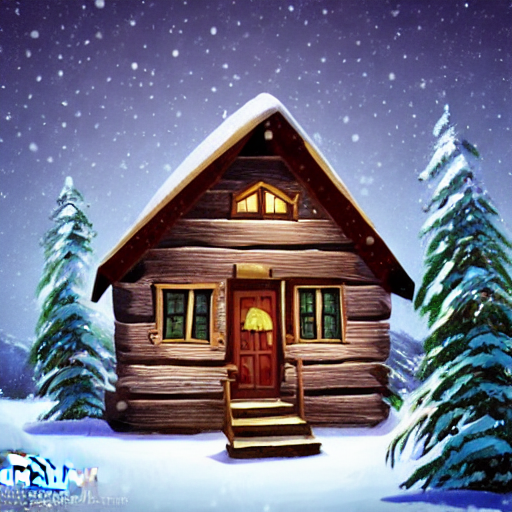

In [48]:
latents_to_pil(latents)[0]

In [49]:
def save_latents(step, latents_x0, latents):
    # To PIL Images
    im_t0 = latents_to_pil(latents_x0)[0]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{step:04}.jpeg')

In [51]:
!mkdir steps

In [52]:
for i in tqdm(range(len(history)-1)):
    save_latents(i, history[i], history[i+1])

  0%|          | 0/29 [00:00<?, ?it/s]

Make and show the progress video (change width to 1024 for full res)

In [53]:
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4

In [56]:
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [57]:
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)